In [1]:
import os

import matplotlib.pyplot as plt

result_dir = "../../../../Redbench/output/generated_workloads/"
dataset = "imdb"
redset_dataset = "serverless"

cluster_id = "cluster_0"
database_id = "database_0"


workloads = [
    "generation_ede5387599ee1e65c105eaa9b17c5c3c",
]

system_to_show = "duckdb"

In [2]:
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import importlib

import plots.load_data_helper

importlib.reload(plots.load_data_helper)
from plots.load_data_helper import assemble_runs_dict

results = assemble_runs_dict(
    result_dir,
    dataset,
    redset_dataset,
    cluster_id,
    database_id,
    workloads,
    filter_string=system_to_show,
)

# flatten the results dict
runs_dict = {}
for workload_name, workload_dict in results.items():
    if workload_name.startswith("OLD_"):
        continue  # skip old workloads

    # hide the hash from the workload name
    workload_name = workload_name.rsplit("_", 1)[0]

    for run_name, df in workload_dict.items():
        if run_name == "redset":
            label = "Redset"
        else:
            label = f"{run_name} ({workload_name})"
            assert label not in runs_dict, f"Duplicate label: {label}"

        runs_dict[label] = df

for k in sorted(runs_dict.keys()):
    print(f"{k}: {len(runs_dict[k])} entries")

Found 1 parquet files in ../../../../Redbench/output/generated_workloads//imdb/serverless/cluster_0/database_0/generation_ede5387599ee1e65c105eaa9b17c5c3c/
Redset: 41624 entries
duckdb (generation): 1000 entries


In [3]:
# split runs into

import plots.load_data_helper

importlib.reload(plots.load_data_helper)
from plots.load_data_helper import group_by_system

per_system_dict = group_by_system(runs_dict)

# Plot Similarity With Redset

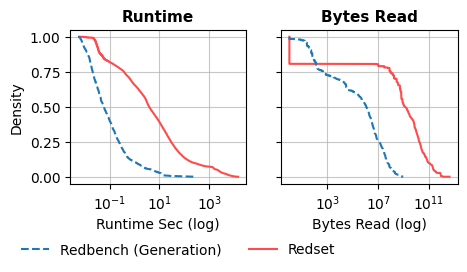

In [6]:
from redbench_eval.plots.load_data_helper import filter_groupby_extract

system_list = ["redset", system_to_show]
metrics = ["runtime_sec", "bytes_read"]

metric_lookup = {
    "runtime_sec": "Runtime",
}

color_dict = {
    "generation": "#1f77b4",  # blue
    "matching": "#ff7f0e",  # orange
    "redset": "#fe4b4b",  # red
    "baseline_round_robin": "#2ca02c",  # green
}

# Define the desired order for the legend
plot_order = ["generation", "matching", "redset", "baseline_round_robin"]

for plot_type in ["cdf"]:
    if plot_type == "cummulative":
        fig, axes = plt.subplots(
            ncols=len(metrics), figsize=(len(metrics) * 3.5, 3), sharey=False
        )
    else:
        fig, axes = plt.subplots(
            ncols=len(metrics), figsize=(len(metrics) * 2.5, 2), sharey=True
        )
    for i, metric in enumerate(metrics):
        plt_ax = axes[i]

        for system in system_list:
            assert system in per_system_dict, (
                f"System {system} not found in per_system_dict"
            )

            config_list = sorted(per_system_dict[system].keys())

            for config in config_list:
                # assert "baseline_round_robin" in per_system_dict[system][config], (
                #     f"Baseline not found for system {system} in per_system_dict, {per_system_dict[system][config].keys()}"
                # )
                # Sort items according to plot_order
                items = list(per_system_dict[system][config].items())
                items_sorted = sorted(
                    items,
                    key=lambda x: plot_order.index(x[0])
                    if x[0] in plot_order
                    else len(plot_order),
                )

                for wl_gen, df in items_sorted:
                    if config != "baseline":
                        continue

                    # drop redset result
                    if system == "redset" and wl_gen != "matching":
                        continue

                    assert metric in df.columns, (
                        f"Metric {metric} not found in dataframe columns {df.columns}"
                    )

                    if system == "redset":
                        label = "Redset"
                        color_key = "redset"
                    else:
                        if wl_gen == "matching":
                            color_key = "matching"
                            label = "Redbench (Matching)"
                        elif wl_gen == "generation":
                            color_key = "generation"
                            label = "Redbench (Generation)"
                        elif wl_gen == "baseline_round_robin":
                            color_key = "baseline_round_robin"
                            label = "Baseline (Round Robin)"
                        else:
                            raise ValueError(f"Unknown config: {config}")

                    if plot_type == "cummulative":
                        data = filter_groupby_extract(
                            df,
                            "all",
                            metric,
                            start_ts=None,
                            end_ts=None,
                            return_cummulated=True,
                            return_all_buckets=True,
                            aggregation_freq="3h",
                        )

                        # normalize to 1
                        data = data / data.max()

                        if label == "Redset":
                            linestyle = "-"
                        elif "Baseline" in label:
                            linestyle = ":"
                        elif "generation" in label.lower():
                            linestyle = "--"
                        elif "matching" in label.lower():
                            linestyle = "dashdot"
                        else:
                            raise ValueError(f"Unknown label: {label}")

                        plt_ax.plot(
                            data.index,
                            data.values,
                            label=label,
                            linestyle=linestyle,
                            color=color_dict.get(color_key, "#000000"),
                        )
                    else:
                        # add cdf
                        sorted_data = df[metric].sort_values()

                        # normalize to 1
                        # sorted_data = (sorted_data / sorted_data.max())+1

                        cdf = (
                            1
                            - (
                                sorted_data.rank(method="first") / len(sorted_data)
                            ).values
                        )
                        # avoid zeros for log scale
                        if metric == "bytes_read":
                            x = sorted_data.clip(lower=1).values
                        else:
                            x = sorted_data.clip(lower=1e-9).values

                        if label == "Redset":
                            linestyle = "-"
                        elif "Baseline" in label:
                            linestyle = ":"
                        elif "generation" in label.lower():
                            linestyle = "--"
                        elif "matching" in label.lower():
                            linestyle = "dashdot"
                        else:
                            raise ValueError(f"Unknown label: {label}")

                        plt_ax.plot(
                            x,
                            cdf,
                            label=label,
                            linestyle=linestyle,
                            color=color_dict.get(color_key, "#000000"),
                        )
                        plt_ax.set_xscale("log")
                        plt_ax.set_xlabel(
                            metric.replace("_", " ").title() + " (log)", fontsize=10
                        )

        if plot_type == "cummulative":
            label = metric_lookup.get(metric, metric.replace("_", " ").title())

            plt_ax.set_ylabel("Relative " + label, fontsize=10)

            plt_ax.tick_params(axis="x", rotation=45)
            for label in plt_ax.get_xticklabels():
                label.set_horizontalalignment("right")

            plt_ax.set_title(
                "Cummulative " + metric.replace("_", " ").title(),
                fontsize=11,
                fontweight="bold",
            )
        else:
            label = metric_lookup.get(metric, metric.replace("_", " ").title())

            plt_ax.set_title(label, fontsize=11, fontweight="bold")
            if i == 0:
                plt_ax.set_ylabel("Density", fontsize=10)

        plt_ax.grid(True, alpha=0.7)

        if i == 0:
            handles, labels = plt_ax.get_legend_handles_labels()

            # Sort legend entries according to plot_order
            def legend_sort_key(label):
                for key in plot_order:
                    if key.lower() in label.lower():
                        return plot_order.index(key)
                return len(plot_order)

            sorted_items = sorted(
                zip(handles, labels), key=lambda x: legend_sort_key(x[1])
            )
            sorted_handles, sorted_labels = (
                zip(*sorted_items) if sorted_items else (handles, labels)
            )
            if plot_type == "cummulative":
                legend = plt_ax.legend(
                    sorted_handles,
                    sorted_labels,
                    ncols=2,
                    bbox_to_anchor=(0.15, -0.3),
                    loc="upper left",
                    frameon=False,
                )
            else:
                legend = plt_ax.legend(
                    sorted_handles,
                    sorted_labels,
                    ncols=2,
                    bbox_to_anchor=(-0.35, -0.3),
                    loc="upper left",
                    frameon=False,
                )

    plt.savefig(f"redset_similarity_{plot_type}.pdf", bbox_inches="tight", pad_inches=0)
